In [1]:
# ============================
# Standard Python imports
# ============================
import os
import json
import datetime as dt
import h5py
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# ============================
# Statistical & scientific libraries
# ============================
from scipy import stats

# ============================
# Seismology / Earthquake libraries
# ============================
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# ============================
# OpenQuake GMPE library - CORRECTED IMPORTS
# ============================
from openquake.hazardlib.gsim.boore_atkinson_2008 import BooreAtkinson2008
from openquake.hazardlib.gsim.campbell_bozorgnia_2008 import CampbellBozorgnia2008
from openquake.hazardlib.gsim.abrahamson_2014 import AbrahamsonEtAl2014
from openquake.hazardlib.imt import PGA, PGV, SA
from openquake.hazardlib.contexts import RuptureContext, SitesContext, DistancesContext
from openquake.hazardlib.const import TRT

# ============================
# Raster Library
# ============================
import rasterio


In [ ]:
# ====================================================
# FUNCTIONS FOR GMPE AND SLIP ANALYSIS
# ====================================================

def calculate_dynamic_stress(magnitude, dist_rup_km, vs30=760, region=None):
    """
    Calculate dynamic stress at a site given earthquake magnitude and distance.
    GMPE is selected based on the region.
    """
    # ------------------------------
    # Select GMPE based on region
    # ------------------------------
    if region in ['HAY', 'HOL', 'CAL', 'PARK', 'SOCAL']:
        gmpe_model = BooreAtkinson2008()
    elif region in ['NAF', 'EAF']:
        gmpe_model = CampbellBozorgnia2008()
    elif region in ['CHAF', 'DSF']:
        gmpe_model = AbrahamsonEtAl2014()
    else:
        gmpe_model = BooreAtkinson2008()  # default fallback

    # ------------------------------
    # Create contexts for OpenQuake GMPE calculation
    # ------------------------------
    rctx = RuptureContext()
    rctx.mag = magnitude
    rctx.rake = 0.0
    rctx.hypo_depth = 10.0

    sctx = SitesContext()
    sctx.vs30 = np.array([vs30])
    sctx.vs30measured = np.array([True])
    sctx.z1pt0 = np.array([48.0])
    sctx.z2pt5 = np.array([2.0])

    dctx = DistancesContext()
    dctx.rrup = np.array([dist_rup_km])
    dctx.rjb = np.array([dist_rup_km])
    dctx.rhypo = np.array([np.sqrt(dist_rup_km**2 + rctx.hypo_depth**2)])
    dctx.rx = np.array([0.0])
    dctx.ry0 = np.array([0.0])

    # ------------------------------
    # Calculate PGV
    # ------------------------------
    imt = PGV()
    try:
        mean_ln_pgv, [sigma_total] = gmpe_model.get_mean_and_stddevs(
            sctx, rctx, dctx, imt, stddev_types=['Total']
        )
        median_pgv = np.exp(mean_ln_pgv[0])
    except Exception:
        # fallback simple approximation
        log_pgv = magnitude - 3.5 * np.log10(dist_rup_km) - 1.5
        median_pgv = 10**log_pgv

    pgv_ms = median_pgv / 100.0
    rho = 2700
    vs = 3500
    tau_dyn = rho * vs * pgv_ms
    return tau_dyn, median_pgv

def compute_background_slope(df_time_slip):
    if len(df_time_slip) < 10:
        return 0, ""
    time_hours = (df_time_slip['Time'] - df_time_slip['Time'].iloc[0]) / pd.Timedelta(hours=1)
    slip_um = df_time_slip['Slip'] * 1e3
    slope_um_hr, _, _, p_value, _ = stats.linregress(time_hours, slip_um)
    slope_flag = ""
    if abs(slope_um_hr) > 0.2 and p_value < 0.05:
        slope_flag = "⚠️ CREEPING" if slope_um_hr > 0 else "⚠️ CONTRACTING"
    elif abs(slope_um_hr) > 0.1:
        slope_flag = "~ weak trend"
    return slope_um_hr, slope_flag

def detect_step_change(df_time_slip, t_event, padding_minutes=20, step_threshold_um=2.5, p_value_thresh=0.01):
    t_step = t_event + pd.Timedelta(minutes=padding_minutes)
    pre_mask = (df_time_slip['Time'] >= t_step - pd.Timedelta(hours=3)) & (df_time_slip['Time'] < t_step)
    post_mask = (df_time_slip['Time'] > t_step) & (df_time_slip['Time'] <= t_step + pd.Timedelta(hours=3))
    slip_pre = df_time_slip['Slip'][pre_mask]
    slip_post = df_time_slip['Slip'][post_mask]
    if len(slip_pre) < 5 or len(slip_post) < 5:
        return 0, 1.0, False
    t_stat, p_value = stats.ttest_ind(slip_pre, slip_post, equal_var=False)
    step_size_um = abs(slip_post.mean() - slip_pre.mean()) * 1e3
    passes = (step_size_um > step_threshold_um) and (p_value < p_value_thresh)
    return step_size_um, p_value, passes

def load_checkpoint():
    CHECKPOINT_DIR = '../../Data/checkpoints/triggering/'
    TRIGGERED_SLIP_FILE = f'{CHECKPOINT_DIR}triggered_slip_results.csv'
    PROGRESS_FILE = f'{CHECKPOINT_DIR}analysis_progress.json'
    triggered_slip = pd.DataFrame()
    triggered_events_df = pd.DataFrame()
    completed_creepmeters = set()
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    if os.path.exists(TRIGGERED_SLIP_FILE):
        triggered_slip = pd.read_csv(TRIGGERED_SLIP_FILE)
    if os.path.exists(PROGRESS_FILE):
        with open(PROGRESS_FILE, 'r') as f:
            completed_creepmeters = set(json.load(f).get('completed_creepmeters', []))
    return triggered_slip, triggered_events_df, completed_creepmeters

def save_checkpoint(triggered_slip, triggered_events_df, completed_creepmeters,abbrv):
    CHECKPOINT_DIR = '../../Data/checkpoints/triggering/'
    TRIGGERED_SLIP_FILE = f'{CHECKPOINT_DIR}{abbrv}_triggered_slip_results.csv'
    TRIGGERED_EVENTS_FILE = f'{CHECKPOINT_DIR}{abbrv}_triggered_events_analysis.csv'
    PROGRESS_FILE = f'{CHECKPOINT_DIR}analysis_progress.json'
    triggered_slip.to_csv(TRIGGERED_SLIP_FILE, index=False)
    triggered_events_df.to_csv(TRIGGERED_EVENTS_FILE, index=False)
    progress_data = {'completed_creepmeters': list(completed_creepmeters), 'last_updated': pd.Timestamp.now().isoformat()}
    with open(PROGRESS_FILE, 'w') as f:
        json.dump(progress_data, f, indent=2)


In [8]:
def query_catalogs(starttime, endtime, lat, long, abbrv, MIN_MAGNITUDE, MAXRADIUS_DEG):
    catalogs = []

    # ------------------------------
    # IRIS
    # ------------------------------
    try:
        client = Client("IRIS")
        iris_cat = client.get_events(
            starttime=starttime, endtime=endtime,
            latitude=lat, longitude=long,
            maxradius=MAXRADIUS_DEG, minmagnitude=MIN_MAGNITUDE
        )
        if iris_cat:
            catalogs.append(("IRIS", iris_cat))
            print(f"    Found {len(iris_cat)} earthquakes in IRIS catalog")
    except Exception as e:
        print(f"    ERROR: Failed to retrieve events from IRIS: {e}")
        

    # ------------------------------
    # USGS
    # ------------------------------
    try:
        client = Client("USGS")
        usgs_cat = client.get_events(
            starttime=starttime, endtime=endtime,
            latitude=lat, longitude=long,
            maxradius=MAXRADIUS_DEG, minmagnitude=MIN_MAGNITUDE
        )
        if usgs_cat:
            catalogs.append(("USGS", usgs_cat))
            print(f"    Found {len(usgs_cat)} earthquakes in USGS catalog")
    except Exception as e:
        print(f"    ERROR: Failed to retrieve events from USGS: {e}")

    # ------------------------------
    # NCEDC (Bay Area)
    # ------------------------------
    if abbrv in ["HAY", "CAL", "HOL", "PARK"]:
        try:
            client = Client("NCEDC")
            ncedc_cat = client.get_events(
                starttime=starttime, endtime=endtime,
                latitude=lat, longitude=long,
                maxradius=MAXRADIUS_DEG, minmagnitude=MIN_MAGNITUDE
            )
            if ncedc_cat:
                catalogs.append(("NCEDC", ncedc_cat))
                print(f"    Found {len(ncedc_cat)} earthquakes in NCEDC catalog")
        except Exception as e:
            print(f"    ERROR: Failed to retrieve events from NCEDC: {e}")

    # ------------------------------
    # SCEDC (SoCal)
    # ------------------------------
    if abbrv == "SOCAL":
        try:
            client = Client("SCEDC")
            socal_cat = client.get_events(
                starttime=starttime, endtime=endtime,
                latitude=lat, longitude=long,
                maxradius=MAXRADIUS_DEG, minmagnitude=MIN_MAGNITUDE
            )
            if socal_cat:
                catalogs.append(("SCEDC", socal_cat))
                print(f"    Found {len(socal_cat)} earthquakes in SCEDC catalog")
        except Exception as e:
            print(f"    ERROR: Failed to retrieve events from SCEDC: {e}")

    # ------------------------------
    # Turkey (NAF / EAF)
    # ------------------------------
    if abbrv in ["NAF", "EAF"]:
        try:
            client = Client("TU")
            tu_cat = client.get_events(
                starttime=starttime, endtime=endtime,
                latitude=lat, longitude=long,
                maxradius=MAXRADIUS_DEG, minmagnitude=MIN_MAGNITUDE
            )
            if tu_cat:
                catalogs.append(("TU", tu_cat))
                print(f"    Found {len(tu_cat)} earthquakes in TU catalog")
        except Exception as e:
            print(f"    ERROR: Failed to retrieve events from TU: {e}")

    # ------------------------------
    # Convert all catalogs into DataFrame
    # ------------------------------
    eq_data = []
    for name, cat in catalogs:
        for event in cat:
            origin = event.preferred_origin() or event.origins[0]
            magnitude = event.preferred_magnitude() or event.magnitudes[0]

            # Collect contributing network codes (ObsPy Event metadata)
            network_codes = set()
            for arr in event.origins:
                if hasattr(arr, "stations") and arr.stations:
                    network_codes.update(arr.stations)
            if not network_codes and hasattr(event, "picks"):
                network_codes.update([p.waveform_id.network_code for p in event.picks])

            eq_data.append({
                "eq_time": origin.time.datetime,
                "magnitude": magnitude.mag,
                "latitude": origin.latitude,
                "longitude": origin.longitude,
                "depth_km": origin.depth / 1000.0 if origin.depth else 0,
                "place": event.resource_id.id.split("/")[-1],
                "source": name,
                "networks": ",".join(sorted(network_codes)) if network_codes else None
            })

    eq_df = pd.DataFrame(eq_data)

    # ------------------------------
    # Remove duplicates (fuzzy matching, keep all sources/networks)
    # ------------------------------
    if not eq_df.empty:
        eq_df = eq_df.sort_values("eq_time").reset_index(drop=True)
        eq_df["eq_time"] = pd.to_datetime(eq_df["eq_time"])

        deduped = []
        seen = []

        for _, row in eq_df.iterrows():
            t, lat, lon, mag = row["eq_time"], row["latitude"], row["longitude"], row["magnitude"]
            source = row["source"]
            networks = row["networks"]

            matched_idx = None
            for i, s in enumerate(seen):
                dt = abs((t - s["eq_time"]).total_seconds())
                dlat = abs(lat - s["latitude"])
                dlon = abs(lon - s["longitude"])
                dmag = abs(mag - s["magnitude"])

                if dt <= 2 and dlat <= 0.02 and dlon <= 0.02 and dmag <= 0.1:
                    matched_idx = i
                    break

            if matched_idx is not None:
                # Merge sources and networks
                seen[matched_idx]["sources"].add(source)
                if networks:
                    seen[matched_idx]["networks"].update(networks.split(","))
            else:
                event = row.to_dict()
                event["sources"] = {source}  # keep as set
                event["networks"] = set(networks.split(",")) if networks else set()
                seen.append(event)

        # Convert sets to comma-separated strings
        for ev in seen:
            ev["sources"] = ",".join(sorted(ev["sources"]))
            ev["networks"] = ",".join(sorted(ev["networks"])) if ev["networks"] else None

        eq_df = pd.DataFrame(seen)

    return eq_df


In [9]:
creepmeters = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes_updated.csv')
creepmeters.drop_duplicates('Creepmeter_abbrv',inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='XMBC'].index,inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='TABC'].index,inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='CHP1'].index,inplace=True)


creepmeters.reset_index(inplace=True,drop=True)
creepmeters_picks = pd.read_csv('../../Data/DATA_tidied/Picks/All_picks_12_JUN_2025.csv',index_col=0)
creepmeters_picks['Start Time'] = pd.to_datetime(creepmeters_picks['Start Time'])
creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Start Time']>dt.datetime(2024,1,1,0,0,0)].index,inplace=True)
networks = creepmeters['Network'].unique()
networks

array(['EAF', 'PARK', 'UTA', 'NAF', 'HAY', 'CHAF', 'HOL', 'DSF', 'SOCAL',
       'RID', 'CAL'], dtype=object)

In [10]:
print(creepmeters['Creepmeter_abbrv'].unique())

['BAL1' 'C461' 'C462' 'CAN1' 'CER1' 'CFW1' 'CHA1' 'CHE1' 'COZ1' 'CPP1'
 'CRR1' 'CTM1' 'CWC3' 'CWN1' 'DS30' 'DU30' 'ESZ1' 'FCR1' 'FE30' 'GB' 'GD'
 'GOK1' 'GOZ1' 'GS' 'HAM1' 'HAS1' 'HAT1' 'INW1' 'IR30' 'ISW1' 'KAR1'
 'KIR1' 'NS45' 'ORM1' 'PAN1' 'PAS1' 'PET1' 'QE30' 'QW30' 'R7' 'RA' 'RB'
 'RR45' 'SC30' 'SEL1' 'SH30' 'SIV1' 'SJN1' 'SU30' 'TAS1' 'TEP1' 'WKR1'
 'WSZ1' 'X461' 'XGH1' 'XHR1' 'XHR2' 'XHR3' 'XHSW' 'XMD1' 'XMM1' 'XMR1'
 'XPK1' 'XPK2' 'XRSW' 'XSC1' 'XSH1' 'XSJ2' 'XSJ3' 'XTA1' 'XVA1' 'YZE1'
 'YZW1' 'COML' 'COLE' 'COLW' 'EASH']


In [11]:
def get_vs30_combined(creepmeters_df, vs30_ca_tiff, afad_excel_path, chaf_excel_path):
    """
    Create a unified Vs30 dictionary for all creepmeters.
    
    California (HAY, HOL, CAL, PARK, SOCAL) -> raster lookup
    Turkey (NAF, EAF) -> nearest AFAD station
    Pakistan (CHAF) -> nearest Zhou et al. 2022 station
    Other networks -> default Vs30 (760 m/s)
    
    Args:
        creepmeters_df: DataFrame with ['Creepmeter_abbrv','Latitude','Longitude','Network']
        vs30_ca_tiff: path to California Vs30 GeoTIFF
        afad_excel_path: path to AFAD Excel metadata file
        chaf_excel_path: path to CHAF Pakistan Excel metadata file
        
    Returns:
        dict: creepmeter abbreviation -> Vs30 (m/s)
    """
    vs30_dict = {}
    
    # --------------------------
    # 1. California creepmeters from raster
    # --------------------------
    ca_networks = ['HAY','HOL','CAL','PARK','SOCAL','UTA','RID']
    ca_creepmeters = creepmeters_df[creepmeters_df['Network'].isin(ca_networks)]
    
    with rasterio.open(vs30_ca_tiff) as src:
        for idx, row in ca_creepmeters.iterrows():
            abbrv = row['Creepmeter_abbrv']
            lon, lat = row['Longitude'], row['Latitude']
            try:
                vs30_value = next(src.sample([(lon, lat)]))[0]
                if vs30_value is None or vs30_value == src.nodata:
                    vs30_value = float('nan')
                vs30_dict[abbrv] = float(vs30_value)
            except Exception as e:
                print(f"Warning: could not extract Vs30 for {abbrv} in CA: {e}")
                vs30_dict[abbrv] = float('nan')
    
    # --------------------------
    # 2. Turkey creepmeters from AFAD
    # --------------------------
    afad_df = pd.read_excel(afad_excel_path, skiprows=2)
    afad_df = afad_df[['Latitude', 'Longitude', 'VS30\n(m/s)', 'SCK Inferred VS30\n(m/s)']]
    afad_df['VS30_filled'] = afad_df['VS30\n(m/s)'].fillna(afad_df['SCK Inferred VS30\n(m/s)'])
    
    turkey_creepmeters = creepmeters_df[creepmeters_df['Network'].isin(['NAF','EAF'])]
    for idx, row in turkey_creepmeters.iterrows():
        abbrv = row['Creepmeter_abbrv']
        cm_lat, cm_lon = row['Latitude'], row['Longitude']
        distances = afad_df.apply(lambda x: geodesic((cm_lat, cm_lon), (x['Latitude'], x['Longitude'])).km, axis=1)
        nearest_idx = distances.idxmin()
        vs30_value = afad_df.loc[nearest_idx, 'VS30_filled']
        if pd.isna(vs30_value):
            print(f"Warning: No Vs30 available for {abbrv} (fallback 760 m/s)")
            vs30_value = 760.0
        vs30_dict[abbrv] = float(vs30_value)
    
    # --------------------------
    # 3. Pakistan creepmeters from Zhou et al. 2022
    # --------------------------
    chaf_df = pd.read_excel(chaf_excel_path,skiprows=1)
    print(chaf_df.columns)

    chaf_df['VS30_filled'] = chaf_df['Inferred VS30 \nby Zhou et al. (2022) \nMethod (m/s)']
    
    pakistan_creepmeters = creepmeters_df[creepmeters_df['Network'] == 'CHAF']
    for idx, row in pakistan_creepmeters.iterrows():
        abbrv = row['Creepmeter_abbrv']
        cm_lat, cm_lon = row['Latitude'], row['Longitude']
        distances = chaf_df.apply(lambda x: geodesic((cm_lat, cm_lon), (x['Latitude (°)'], x['Longitude (°)'])).km, axis=1)
        nearest_idx = distances.idxmin()
        vs30_value = chaf_df.loc[nearest_idx, 'VS30_filled']
        if pd.isna(vs30_value):
            print(f"Warning: No VS30 available for {abbrv} (fallback 760 m/s)")
            vs30_value = 760.0
        vs30_dict[abbrv] = float(vs30_value)
    
    # --------------------------
    # 4. Other networks -> default
    # --------------------------
    other_creepmeters = creepmeters_df[~creepmeters_df['Network'].isin(ca_networks + ['NAF','EAF','CHAF'])]
    for idx, row in other_creepmeters.iterrows():
        abbrv = row['Creepmeter_abbrv']
        vs30_dict[abbrv] = 760.0  # default rock
    
    return vs30_dict


vs30_ca_tiff = "../../Data/Vs30_California/California_vs30_Wills15_hybrid.tif"
afad_excel_path = "../../Data/Vs30_Turkiye/VS30 Map for Türkiye and Inferred VS30 of AFAD Strong-Motion Network Stations 20241101/AFAD_Station_File_Measured_SCKInferred_VS30_20241101.xlsx"
chaf_excel_path = "../../Data/Vs30_Pakistan/VS30_Pakistan_Kashmir.xlsx"
vs30_map = get_vs30_combined(creepmeters, vs30_ca_tiff, afad_excel_path,chaf_excel_path)

# Quick check
for k, v in list(vs30_map.items()):
    print(f"{k}: Vs30 = {v:.1f} m/s")


Index(['Unnamed: 0', 'SN', 'Longitude (°)', 'Latitude (°)',
       'Inferred VS30 \nby Zhou et al. (2022) \nMethod (m/s)'],
      dtype='object')
C461: Vs30 = 467.8 m/s
C462: Vs30 = 467.8 m/s
CAN1: Vs30 = nan m/s
CFW1: Vs30 = 373.2 m/s
COZ1: Vs30 = 351.9 m/s
CPP1: Vs30 = 467.1 m/s
CRR1: Vs30 = 351.9 m/s
CTM1: Vs30 = 351.8 m/s
CWC3: Vs30 = 351.9 m/s
CWN1: Vs30 = 351.9 m/s
DU30: Vs30 = 385.1 m/s
FCR1: Vs30 = 351.9 m/s
FE30: Vs30 = 351.9 m/s
GB: Vs30 = 351.9 m/s
GD: Vs30 = 427.8 m/s
GS: Vs30 = 351.9 m/s
IR30: Vs30 = 351.9 m/s
NS45: Vs30 = 350.4 m/s
QE30: Vs30 = 474.1 m/s
QW30: Vs30 = 351.9 m/s
R7: Vs30 = 293.5 m/s
RA: Vs30 = 351.9 m/s
RB: Vs30 = 351.9 m/s
RR45: Vs30 = 216.3 m/s
SC30: Vs30 = 351.9 m/s
SH30: Vs30 = 351.7 m/s
SJN1: Vs30 = 351.9 m/s
SU30: Vs30 = 325.8 m/s
WKR1: Vs30 = 389.2 m/s
X461: Vs30 = 470.9 m/s
XGH1: Vs30 = 351.9 m/s
XHR1: Vs30 = 468.4 m/s
XHR2: Vs30 = 468.4 m/s
XHR3: Vs30 = 468.4 m/s
XHSW: Vs30 = 457.5 m/s
XMD1: Vs30 = 452.3 m/s
XMM1: Vs30 = 412.5 m/s
XMR1: Vs30 = 372.

In [12]:
def extract_event_window(df, arrival_time, sampling_rate_s):
    # Find nearest timestamp to the arrival
    time_diffs = np.abs(np.array(df['Time'], dtype='datetime64[ns]') - arrival_time)
    nearest_idx = np.argmin(time_diffs)
    nearest_time = df['Time'].iloc[nearest_idx]

    # Adaptive windowing
    if sampling_rate_s > 600:  # sparse sampling (>10 min per sample)
        points_each_side = 5
        start_idx = max(0, nearest_idx - points_each_side)
        end_idx = min(len(df), nearest_idx + points_each_side)
        df_window = df.iloc[start_idx:end_idx].copy()
    else:
        # dense sampling: ±1 hour window
        mask = (
            (df['Time'] >= nearest_time - dt.timedelta(hours=1)) &
            (df['Time'] <= nearest_time + dt.timedelta(hours=1))
        )
        df_window = df[mask].copy()

    return df_window

In [15]:
# ====================================================
# ================= MAIN ANALYSIS LOOP ===============
# ====================================================

# Load creepmeters metadata
creepmeters = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes_updated.csv')
creepmeters.drop_duplicates('Creepmeter_abbrv', inplace=True)

# Drop problematic or duplicate stations
for drop_abbrv in ['XMBC', 'TABC']:
    creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']==drop_abbrv].index, inplace=True)
creepmeters.reset_index(inplace=True, drop=True)

# Load all picks (creep events)
creepmeters_picks = pd.read_csv('../../Data/DATA_tidied/Final_Catalogue/Digital_catalogue_of_5000_aseismic_slip_events_recorded_by_creepmeters.csv', index_col=0)
creepmeters_picks['Start Time'] = pd.to_datetime(creepmeters_picks['Start Time'])
# Optional: remove picks beyond 2024-01-01
creepmeters_picks = creepmeters_picks[creepmeters_picks['Start Time'] <= dt.datetime(2024,1,1,0,0,0)]

# Identify networks to iterate
networks = creepmeters['Network'].unique()

# ------------------------------
# DEFINE ANALYSIS PARAMETERS
# ------------------------------
RADIUS_KM = 500                   # Max distance from creepmeter to consider event
MAXRADIUS_DEG = RADIUS_KM / 111.0  # Convert km to degrees roughly
MIN_MAGNITUDE = 3.0
MIN_DYNAMIC_STRESS_PA = 2000      # 2 kPa threshold
STEP_THRESHOLD_UM = 2.5           # µm threshold for instrument step detection
P_VALUE_THRESHOLD = 0.01          # Statistical significance threshold
PADDING_MINUTES = 20               # Minutes after surface wave arrival for step analysis

# ------------------------------
# LOAD EXISTING PROGRESS
# ------------------------------
triggered_slip, triggered_events_df, completed_creepmeters = load_checkpoint()
triggered_events_df = pd.DataFrame()  # start fresh

print(f"Starting triggered slip analysis...")
print(f"Search radius: {RADIUS_KM} km | Min magnitude: {MIN_MAGNITUDE}")
print(f"Min dynamic stress: {MIN_DYNAMIC_STRESS_PA/1000:.1f} kPa")
print(f"Step threshold: {STEP_THRESHOLD_UM} µm | P-value threshold: {P_VALUE_THRESHOLD}")
print("-"*60)

# ------------------------------
# LOOP OVER NETWORKS
# ------------------------------
for j, network in enumerate(networks):
    print(f"\nProcessing network: {network}")

    # Optional filter: only process target networks
    if network not in ['HOL','HAY','CAL','PARK','SOCAL','NAF','EAF','CHAF','UTA','RID','DSF']:
        print(f"  Skipping {network} - not in target networks")
        continue

    # Filter creepmeters for this network
    creepmeters_network = creepmeters[creepmeters['Network'] == network].copy()
    if creepmeters_network.empty:
        print(f"  No creepmeters found for network {network}")
        continue

    print(f"  Found {len(creepmeters_network)} creepmeters in {network}")

    # ------------------------------
    # LOOP OVER CREEPMETERS
    # ------------------------------
    for i, (idx, creepmeter) in enumerate(creepmeters_network.iterrows()):
        abbrv = creepmeter['Creepmeter_abbrv']
        lat = creepmeter['Latitude']
        long = creepmeter['Longitude']
        region = creepmeter['Network']  # e.g., HAY, HOL, SOCAL, etc.
        sampling_rate = creepmeter['Sampling rate, Hz']
        sampling_rate = int(1/sampling_rate)    # convert to seconds
        # Skip already completed creepmeters
        if abbrv in completed_creepmeters:
            print(f"\n  [{i+1}/{len(creepmeters_network)}] Skipping {abbrv} - already completed")
            continue

        print(f"\n  [{i+1}/{len(creepmeters_network)}] Processing {abbrv} at ({lat:.3f}, {long:.3f}) | Region: {region}")



        # ------------------------------
        # LOAD CREEPMETER SLIP DATA
        # ------------------------------
        h5_file = f'../../Data/DATA_tidied/HDF5/{abbrv}.h5'
        try:
            with h5py.File(h5_file, 'r') as f:
                df = pd.DataFrame()
                exclude_keys = ['Temperature', 'Temperature_1T', 'Temperature_5T', 
                                'Daily_measurements', 'Manual_measurements', 'Orthogonal']
                valid_keys = [key for key in f.keys() if key not in exclude_keys]

                for key in valid_keys:
                    data = f[key]
                    data_keys = list(data.keys())
                    slip = data[data_keys[0]][:]
                    time = data[data_keys[1]][:]

                    decoded_time = [byte_str.decode('utf-8') for byte_str in time]
                    decoded_time = pd.to_datetime(decoded_time)

                    df_section = pd.DataFrame({'Time': decoded_time, 'Slip': slip})
                    df = pd.concat([df, df_section], ignore_index=True)
        except Exception as e:
            print(f"    ERROR: Failed to load HDF5 data for {abbrv}: {e}")
            continue

        if df.empty:
            print(f"    No slip data loaded for {abbrv}")
            continue

        df = df.sort_values(by='Time').reset_index(drop=True)
        print(f"    Loaded {len(df)} slip measurements")

        starttime = UTCDateTime(df['Time'].iloc[0].strftime('%Y-%m-%d'))
        endtime = UTCDateTime(df['Time'].iloc[-1].strftime('%Y-%m-%d'))
        print(f"    Querying earthquakes from {starttime.date} to {endtime.date}")
        # ------------------------------
        # QUERY EARTHQUAKE CATALOGS
        # ------------------------------
        eq_df = query_catalogs(starttime, endtime, lat, long, region, MIN_MAGNITUDE, MAXRADIUS_DEG)
        # ------------------------------
        # PROCESS EACH EARTHQUAKE
        # ------------------------------
        creepmeter_events = []  # local storage for this creepmeter only

        for eq_idx, eq in eq_df.iterrows():
            dist_km = geodesic((lat, long), (eq['latitude'], eq['longitude'])).km
            if dist_km > RADIUS_KM:
                continue

            tau_dyn, median_pgv = calculate_dynamic_stress(eq['magnitude'], dist_km, vs30_map.get(abbrv, 760.0), region)
            '''if tau_dyn < MIN_DYNAMIC_STRESS_PA:
                continue'''
            
            # Estimate arrival times
            p_arrival_time = np.datetime64(eq['eq_time']) + np.timedelta64(int(dist_km/6), 's')
            s_arrival_time = np.datetime64(eq['eq_time']) + np.timedelta64(int(dist_km/3.5), 's')
            surface_arrival_time = np.datetime64(eq['eq_time']) + np.timedelta64(int(dist_km/3), 's')

            # extract slip windows around arrivals
            df_p = extract_event_window(df, p_arrival_time, sampling_rate)
            df_s = extract_event_window(df, s_arrival_time, sampling_rate)
            df_surface = extract_event_window(df, surface_arrival_time, sampling_rate)



            # Skip if too little data for analysis
            if any(len(d) < 5 for d in [df_p, df_s, df_surface]):
                continue

            # --- Run step detection for each phase ---
            step_p_um, pval_p, pass_p = detect_step_change(
                df_p, pd.Timestamp(p_arrival_time),
                padding_minutes=PADDING_MINUTES,
                step_threshold_um=STEP_THRESHOLD_UM,
                p_value_thresh=P_VALUE_THRESHOLD
            )

            step_s_um, pval_s, pass_s = detect_step_change(
                df_s, pd.Timestamp(s_arrival_time),
                padding_minutes=PADDING_MINUTES,
                step_threshold_um=STEP_THRESHOLD_UM,
                p_value_thresh=P_VALUE_THRESHOLD
            )

            step_surface_um, pval_surface, pass_surface = detect_step_change(
                df_surface, pd.Timestamp(surface_arrival_time),
                padding_minutes=PADDING_MINUTES,
                step_threshold_um=STEP_THRESHOLD_UM,
                p_value_thresh=P_VALUE_THRESHOLD
            )

            # --- Collect results ---
            creep_event = {
                'eq_iris_id': eq['place'][14:],
                'eq_time': eq['eq_time'],
                'eq_latitude': eq['latitude'],
                'eq_longitude': eq['longitude'],
                'eq_depth_km': eq['depth_km'],
                'eq_magnitude': eq['magnitude'],
                'creepmeter': abbrv,
                'creepmeter_latitude': lat,
                'creepmeter_longitude': long,
                'dynamic_stress_kpa': tau_dyn / 1000,
                'distance_km': dist_km,

                # Arrival times
                'p_arrival_time': p_arrival_time,
                's_arrival_time': s_arrival_time,
                'surface_arrival_time': surface_arrival_time,

                # Step detection results
                'p_step_size_um': step_p_um,
                'p_p_value': pval_p,
                'p_passes_filters': pass_p,

                's_step_size_um': step_s_um,
                's_p_value': pval_s,
                's_passes_filters': pass_s,

                'surface_step_size_um': step_surface_um,
                'surface_p_value': pval_surface,
                'surface_passes_filters': pass_surface,

                # Optional combined flag if any phase passes
                'any_phase_passes': pass_p or pass_s or pass_surface
            }
            creepmeter_events.append(creep_event)

        # ------------------------------
        # SAVE THIS CREEPMETER'S RESULTS
        # ------------------------------
        creepmeter_events_df = pd.DataFrame(creepmeter_events)
        outfile = f"../../Data/checkpoints/triggering/{abbrv}_triggered_events_analysis.csv"
        creepmeter_events_df.to_csv(outfile, index=False)

        print(f"  Saved {len(creepmeter_events_df)} events for {abbrv} -> {outfile}")

        # update checkpoint progress (for slip + completion flag)
        completed_creepmeters.add(abbrv)
        save_checkpoint(triggered_slip, creepmeter_events_df, completed_creepmeters, abbrv)



Starting triggered slip analysis...
Search radius: 500 km | Min magnitude: 3.0
Min dynamic stress: 2.0 kPa
Step threshold: 2.5 µm | P-value threshold: 0.01
------------------------------------------------------------

Processing network: EAF
  Found 14 creepmeters in EAF

  [1/14] Processing BAL1 at (37.990, 38.199) | Region: EAF
    Loaded 509808 slip measurements
    Querying earthquakes from 2023-03-12 to 2023-09-05
    Found 112 earthquakes in IRIS catalog
    Found 117 earthquakes in USGS catalog
    ERROR: Failed to retrieve events from TU: The FDSN service shortcut `TU` is unknown.


/Users/dagi9522/miniconda3/envs/Aseismic/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


KeyboardInterrupt: 

In [16]:
import fnmatch

folder_path = "../../Data/checkpoints/triggering"

file_paths = [
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f))
    and fnmatch.fnmatch(f, "*_triggered_events_analysis.csv")
]

print(file_paths)

['../../Data/checkpoints/triggering/XPK2_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/C462_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/HAM1_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/XSC1_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/CTM1_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/GOK1_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/NS45_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/GS_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/CHE1_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/XSJ2_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/SH30_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/DS30_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/XTA1_triggered_events_analysis.csv', '../../Data/checkpoints/triggering/INW1_triggered_events_analysis

In [17]:
for i in range(len(file_paths)):
    print(file_paths[i])
    test_df = pd.read_csv(file_paths[i])
    

../../Data/checkpoints/triggering/XPK2_triggered_events_analysis.csv
../../Data/checkpoints/triggering/C462_triggered_events_analysis.csv
../../Data/checkpoints/triggering/HAM1_triggered_events_analysis.csv
../../Data/checkpoints/triggering/XSC1_triggered_events_analysis.csv
../../Data/checkpoints/triggering/CTM1_triggered_events_analysis.csv
../../Data/checkpoints/triggering/GOK1_triggered_events_analysis.csv
../../Data/checkpoints/triggering/NS45_triggered_events_analysis.csv
../../Data/checkpoints/triggering/GS_triggered_events_analysis.csv
../../Data/checkpoints/triggering/CHE1_triggered_events_analysis.csv
../../Data/checkpoints/triggering/XSJ2_triggered_events_analysis.csv
../../Data/checkpoints/triggering/SH30_triggered_events_analysis.csv
../../Data/checkpoints/triggering/DS30_triggered_events_analysis.csv
../../Data/checkpoints/triggering/XTA1_triggered_events_analysis.csv
../../Data/checkpoints/triggering/INW1_triggered_events_analysis.csv
../../Data/checkpoints/triggering/QW

In [18]:
test_df

,eq_iris_id,eq_time,eq_latitude,eq_longitude,eq_depth_km,eq_magnitude,creepmeter,creepmeter_latitude,creepmeter_longitude,dynamic_stress_kpa,...,p_step_size_um,p_p_value,p_passes_filters,s_step_size_um,s_p_value,s_passes_filters,surface_step_size_um,surface_p_value,surface_passes_filters,any_phase_passes
0,350942,1993-12-15 10:26:22.730,36.177000,-120.253300,18.300,3.00,CFW1,37.532,-121.952,0.000021,...,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,False
1,351314,1993-12-16 00:43:58.190,38.604600,-119.448600,5.000,3.90,CFW1,37.532,-121.952,0.000096,...,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,False
2,nc388950&format=quakeml,1993-12-16 00:43:58.220,38.557667,-119.526333,7.407,3.85,CFW1,37.532,-121.952,0.000097,...,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,False
3,NaN,1993-12-16 10:23:44.720,37.630333,-118.819667,0.874,3.14,CFW1,37.532,-121.952,0.000012,...,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,False
4,351609,1993-12-16 10:23:45.640,37.670300,-118.798300,3.300,3.20,CFW1,37.532,-121.952,0.000013,...,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,0.000000,1.000000e+00,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13733,NaN,2024-10-05 15:51:46.110,37.791667,-119.121833,-0.010,3.00,CFW1,37.532,-121.952,0.000012,...,3.862298,5.633597e-58,True,3.944817,8.902632e-59,True,3.959877,7.547454e-59,True,True
13734,nc75070761&format=quakeml,2024-10-05 16:24:35.160,40.367333,-124.591667,25.930,3.43,CFW1,37.532,-121.952,0.000007,...,5.300000,7.543441e-47,True,5.353276,1.739751e-47,True,5.453963,4.190152e-49,True,True
13735,ci40752591&format=quakeml,2024-10-06 00:25:57.740,36.145167,-117.081167,1.830,3.59,CFW1,37.532,-121.952,0.000006,...,0.162500,2.814652e-02,False,0.155556,3.518577e-02,False,0.191108,1.316514e-02,False,False
13736,NaN,2024-10-06 00:25:57.950,36.113167,-117.090332,-1.020,3.66,CFW1,37.532,-121.952,0.000006,...,0.162500,2.814652e-02,False,0.155556,3.518577e-02,False,0.191108,1.316514e-02,False,False


In [19]:
file_paths[-1]

'../../Data/checkpoints/triggering/CFW1_triggered_events_analysis.csv'

In [20]:
eq_steps = pd.DataFrame()
for i in range(len(file_paths)):
    print(i,file_paths[i])
    if file_paths[i] in  ['../../Data/checkpoints/triggering/DS30_triggered_events_analysis.csv','../../Data/checkpoints/triggering/CHA1_triggered_events_analysis.csv']:
        continue    

    test_df = pd.read_csv(file_paths[i])
    test_df.drop(test_df[pd.to_datetime(test_df['eq_time'])>dt.datetime(2024,1,1)].index,inplace=True)
    #test_df.drop(test_df[test_df['step_size_um']<2.5].index,inplace=True)
    test_df.drop(test_df[test_df['any_phase_passes']!=True].index,inplace=True)
    test_df.reset_index(inplace=True,drop=True)
    eq_steps = pd.concat([eq_steps,test_df],ignore_index=True)

eq_steps.sort_values(by=['eq_time','creepmeter'],inplace=True)
eq_steps.reset_index(inplace=True,drop=True)
print(len(eq_steps))
eq_steps.head()

0 ../../Data/checkpoints/triggering/XPK2_triggered_events_analysis.csv
1 ../../Data/checkpoints/triggering/C462_triggered_events_analysis.csv
2 ../../Data/checkpoints/triggering/HAM1_triggered_events_analysis.csv
3 ../../Data/checkpoints/triggering/XSC1_triggered_events_analysis.csv
4 ../../Data/checkpoints/triggering/CTM1_triggered_events_analysis.csv
5 ../../Data/checkpoints/triggering/GOK1_triggered_events_analysis.csv
6 ../../Data/checkpoints/triggering/NS45_triggered_events_analysis.csv
7 ../../Data/checkpoints/triggering/GS_triggered_events_analysis.csv
8 ../../Data/checkpoints/triggering/CHE1_triggered_events_analysis.csv
9 ../../Data/checkpoints/triggering/XSJ2_triggered_events_analysis.csv
10 ../../Data/checkpoints/triggering/SH30_triggered_events_analysis.csv
11 ../../Data/checkpoints/triggering/DS30_triggered_events_analysis.csv
12 ../../Data/checkpoints/triggering/XTA1_triggered_events_analysis.csv
13 ../../Data/checkpoints/triggering/INW1_triggered_events_analysis.csv
14 .

,eq_iris_id,eq_time,eq_latitude,eq_longitude,eq_depth_km,eq_magnitude,creepmeter,creepmeter_latitude,creepmeter_longitude,dynamic_stress_kpa,...,p_step_size_um,p_p_value,p_passes_filters,s_step_size_um,s_p_value,s_passes_filters,surface_step_size_um,surface_p_value,surface_passes_filters,any_phase_passes
0,2888842,1980-01-30 08:36:23.710,37.643200,-118.879500,5.000,3.00,XMR1,36.595,-121.187,0.000015,...,3.500,1.501774e-03,True,3.500,1.501774e-03,True,3.500,1.501774e-03,True,True
1,ci10070350&format=quakeml,1980-01-30 21:05:42.850,38.373167,-118.259500,6.000,3.03,XMR1,36.595,-121.187,0.000005,...,11.725,1.063731e-08,True,11.725,1.063731e-08,True,11.725,1.063731e-08,True,True
2,nc1050679&format=quakeml,1980-01-31 03:28:50.660,36.246333,-120.804833,6.533,3.00,XMR1,36.595,-121.187,0.003010,...,4.375,1.583695e-04,True,4.375,1.583695e-04,True,4.375,1.583695e-04,True,True
3,2884729,1980-02-16 01:45:11.560,34.112100,-119.696700,2.300,3.10,XMR1,36.595,-121.187,0.000007,...,4.200,5.121073e-03,True,4.200,5.121073e-03,True,4.200,5.121073e-03,True,True
4,ci10071182&format=quakeml,1980-02-16 01:45:14.680,34.279333,-119.616833,0.580,3.09,XMR1,36.595,-121.187,0.000008,...,4.200,5.121073e-03,True,4.200,5.121073e-03,True,4.200,5.121073e-03,True,True


In [21]:
eq_steps['p_arrival_time']

0         1980-01-30 08:37:02.710
1         1980-01-30 21:06:36.850
2         1980-01-31 03:28:58.660
3         1980-02-16 01:46:02.560
4         1980-02-16 01:46:02.680
                   ...           
106842    2023-12-30 08:29:53.160
106843    2023-12-30 08:29:54.160
106844    2023-12-30 13:26:27.766
106845    2023-12-31 16:39:05.833
106846    2023-12-31 17:07:17.628
Name: p_arrival_time, Length: 106847, dtype: object

In [22]:
slip_events = pd.read_csv('../../Data/DATA_tidied/Final_Catalogue/Digital_catalogue_of_5000_aseismic_slip_events_recorded_by_creepmeters.csv')

In [23]:
slip_events

,Event_id,Start Time,End Time,Network,Creepmeter full name,Creepmeter abbreviation,Latitude,Longitude,Fault,Event type,"Sampling rate, s","Displacement, mm","Duration, hrs"
0,0000_XMR1,1980-02-19 14:30:00,1980-02-20 21:29:59,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.190000,30.999722
1,0001_XMR1,1980-02-21 06:29:59,1980-02-23 08:10:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.282000,49.666944
2,0002_XMR1,1980-07-22 19:59:59,1980-07-24 19:30:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.211000,47.500278
3,0003_XMR1,1980-09-10 09:09:59,1980-09-12 03:29:59,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,1.063000,42.333333
4,0004_XMR1,1980-12-13 12:20:00,1980-12-13 20:50:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.127000,8.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,5860_WKR1,2023-12-18 17:50:00,2023-12-20 20:50:00,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.114000,51.000000
5692,5861_WKR1,2023-12-20 20:39:59,2023-12-21 16:39:59,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.152000,20.000000
5693,5862_WKR1,2023-12-21 17:19:59,2023-12-22 18:40:00,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.162000,25.333611
5694,5863_DS30,2023-12-23 04:59:00,2024-01-11 06:59:00,DSF,Dead Sea,DS30,31.23655,35.36525,Dead Sea Fault,Episodic Creep Event (ECE),3600,0.565803,458.000000


In [26]:
import haversine

In [27]:
df_triggered = pd.DataFrame()
window = 5  # number of creep samples before/after

for i in range(len(creepmeters)):
    abbrv = creepmeters['Creepmeter_abbrv'].iloc[i]

    # Extract times for this creepmeter
    possible_eq_ptriggers = eq_steps[eq_steps['creepmeter']==abbrv][['p_arrival_time','p_step_size_um', 'eq_magnitude', 'eq_latitude', 'eq_longitude','eq_time','eq_depth_km','dynamic_stress_kpa']]
    possible_eq_striggers = eq_steps[eq_steps['creepmeter']==abbrv][['s_arrival_time','s_step_size_um', 'eq_magnitude', 'eq_latitude', 'eq_longitude','eq_time','eq_depth_km','dynamic_stress_kpa']]
    possible_eq_surfacetriggers = eq_steps[eq_steps['creepmeter']==abbrv][['surface_arrival_time','surface_step_size_um', 'eq_magnitude', 'eq_latitude', 'eq_longitude','eq_time','eq_depth_km','dynamic_stress_kpa']]
    possible_slip_events = slip_events[slip_events['Creepmeter abbreviation']==abbrv]

    s1 = possible_slip_events['Start Time']
    event_nos = possible_slip_events['Event_id']
    sampling_rate = possible_slip_events['Sampling rate, s']
    creepmeter_lat = possible_slip_events['Latitude']
    creepmeter_lon = possible_slip_events['Longitude']
    creepmeter_network = possible_slip_events['Network']

    if s1.empty:
        continue

    # Combine EQs into one DataFrame with type
    s2 = pd.concat([
        pd.DataFrame({
            'time': possible_eq_ptriggers['p_arrival_time'],
            'type': 'p',
            'magnitude': possible_eq_ptriggers['eq_magnitude'],
            'latitude': possible_eq_ptriggers['eq_latitude'],
            'longitude': possible_eq_ptriggers['eq_longitude'],
            'depth_km': possible_eq_ptriggers['eq_depth_km'],
            'origin time': possible_eq_ptriggers['eq_time'],
            'dynamic_stress_kpa': possible_eq_ptriggers['dynamic_stress_kpa'].astype(float),
            'p_step_size_um': possible_eq_ptriggers['p_step_size_um'],
        }),
        pd.DataFrame({
            'time': possible_eq_striggers['s_arrival_time'],
            'type': 's',
            'magnitude': possible_eq_striggers['eq_magnitude'],
            'latitude': possible_eq_striggers['eq_latitude'],
            'longitude': possible_eq_striggers['eq_longitude'],
            'depth_km': possible_eq_striggers['eq_depth_km'],
            'origin time': possible_eq_striggers['eq_time'],
            'dynamic_stress_kpa': possible_eq_striggers['dynamic_stress_kpa'].astype(float),
            's_step_size_um': possible_eq_striggers['s_step_size_um']
        }),
        pd.DataFrame({
            'time': possible_eq_surfacetriggers['surface_arrival_time'],
            'type': 'surface',
            'magnitude': possible_eq_surfacetriggers['eq_magnitude'],
            'latitude': possible_eq_surfacetriggers['eq_latitude'],
            'longitude': possible_eq_surfacetriggers['eq_longitude'],
            'depth_km': possible_eq_surfacetriggers['eq_depth_km'],
            'origin time': possible_eq_surfacetriggers['eq_time'],
            'dynamic_stress_kpa': possible_eq_surfacetriggers['dynamic_stress_kpa'].astype(float),
            'surface_step_size_um': possible_eq_surfacetriggers['surface_step_size_um']
        })
    ], ignore_index=True)

    s2['time'] = pd.to_datetime(s2['time'])
    if s2.empty:
        continue

    # Convert to numpy for fast computation
    s1_np = s1.values.astype('datetime64[ns]')
    s2_np = s2['time'].values.astype('datetime64[ns]')

    # Loop through each slip event in order
    for j, slip_time in enumerate(s1_np):
        # Find the closest EQ index
        closest_idx = np.argmin(np.abs(s2_np - slip_time))

        # Select a window of ±window indices
        idx_window = np.arange(max(0, closest_idx - window), min(len(s2_np), closest_idx + window + 1))

        eq_window = s2.iloc[idx_window].copy()

        # Add slip event info
        eq_window['event_ID'] = event_nos.iloc[j]
        eq_window['cm latitude'] = creepmeter_lat.iloc[j]
        eq_window['cm longitude'] = creepmeter_lon.iloc[j]
        eq_window['creepmeter'] = abbrv
        eq_window['creepmeter network'] = creepmeter_network.iloc[j]
        eq_window['cm slip start time'] = slip_time
        eq_window['cm next sample time'] = slip_time + pd.Timedelta(seconds = sampling_rate.iloc[j])
        eq_window['sampling rate, s'] = sampling_rate.iloc[j]

        # Collapse step size columns into single string
        step_cols = ['p_step_size_um','s_step_size_um','surface_step_size_um']
        eq_window['step size um'] = eq_window[step_cols].apply(lambda row: ', '.join(str(x) for x in row if pd.notna(x)), axis=1)

        # Compute time difference in seconds
        eq_window['time difference, s'] = (eq_window['time'].values - slip_time) / np.timedelta64(1,'s')

        # Keep the same column order as your original df_triggered
        eq_window = eq_window[[
            'event_ID', 'cm latitude', 'cm longitude', 'creepmeter','creepmeter network', 'cm slip start time','cm next sample time',
            'sampling rate, s', 'origin time', 'time', 'type', 'time difference, s',
            'magnitude', 'latitude', 'longitude', 'depth_km', 'dynamic_stress_kpa', 'step size um'
        ]]

        # Rename columns to match your original layout
        eq_window = eq_window.rename(columns={
            'origin time': 'earthquake origin time',
            'time': 'closest_eq phase arrival time',
            'type': 'closest_eq phase',
            'latitude': 'eq latitude',
            'longitude': 'eq longitude',
            'depth_km': 'depth km',
            'dynamic_stress_kpa': 'dynamic stress kpa'
        })

        df_triggered = pd.concat([df_triggered, eq_window], ignore_index=True)


In [28]:
df_triggered.drop(df_triggered[df_triggered['time difference, s']>4800].index,inplace=True)
df_triggered.drop(df_triggered[abs(df_triggered['time difference, s'])>5*df_triggered['sampling rate, s']].index,inplace=True)
df_triggered.reset_index(inplace=True,drop=True)
df_triggered['diastance km'] = df_triggered.apply(
    lambda row: haversine.haversine(
        (row['cm latitude'], row['cm longitude']),
        (row['eq latitude'], row['eq longitude'])
    ), axis=1
)
df_triggered

,event_ID,cm latitude,cm longitude,creepmeter,creepmeter network,cm slip start time,cm next sample time,"sampling rate, s",earthquake origin time,closest_eq phase arrival time,closest_eq phase,"time difference, s",magnitude,eq latitude,eq longitude,depth km,dynamic stress kpa,step size um,diastance km
0,5748_BAL1,37.9903,38.1990,BAL1,EAF,2023-08-24 05:33:16,2023-08-24 05:34:16,60,2023-08-24 05:35:24.510,2023-08-24 05:35:28.510,p,132.510,4.80,38.212500,38.181500,10.000,2.513513e+00,104.36524691357984,24.754953
1,2146_C461,35.7240,-120.2820,C461,PARK,2004-10-09 04:30:00,2004-10-09 04:40:00,600,2004-10-09 03:45:47.450,2004-10-09 03:47:23.450,surface,-2556.550,4.00,37.951400,-118.589600,3.600,7.227906e-05,8.574999999993338,289.860792
2,2146_C461,35.7240,-120.2820,C461,PARK,2004-10-09 04:30:00,2004-10-09 04:40:00,600,2004-10-09 03:45:48.680,2004-10-09 03:47:24.680,surface,-2555.320,4.52,37.978833,-118.658833,5.445,2.409386e-04,8.574999999993338,289.334910
3,2146_C461,35.7240,-120.2820,C461,PARK,2004-10-09 04:30:00,2004-10-09 04:40:00,600,2004-10-09 03:48:02.410,2004-10-09 03:49:38.410,surface,-2421.590,3.30,37.971800,-118.663200,8.000,1.467148e-05,8.574999999993338,288.466724
4,2146_C461,35.7240,-120.2820,C461,PARK,2004-10-09 04:30:00,2004-10-09 04:40:00,600,2004-10-09 03:50:57.860,2004-10-09 03:52:33.860,surface,-2246.140,3.00,37.972800,-118.660900,2.200,7.335474e-06,8.777777777780216,288.664767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,3716_XVA1,35.9220,-120.4620,XVA1,PARK,2014-07-05 16:39:59,2014-07-05 16:49:59,600,2014-07-05 16:59:34.930,2014-07-05 17:00:36.930,p,1237.930,4.50,34.198000,-116.937400,10.600,9.334869e-05,18.888888888909605,373.677546
705,3716_XVA1,35.9220,-120.4620,XVA1,PARK,2014-07-05 16:39:59,2014-07-05 16:49:59,600,2014-07-05 17:00:26.100,2014-07-05 17:01:26.100,p,1287.100,4.90,34.274900,-117.010500,11.100,2.582927e-04,18.888888888909605,363.476542
706,3716_XVA1,35.9220,-120.4620,XVA1,PARK,2014-07-05 16:39:59,2014-07-05 16:49:59,600,2014-07-05 17:00:26.490,2014-07-05 17:01:26.490,p,1287.490,3.39,34.274333,-117.017833,8.094,8.024021e-06,18.888888888909605,362.933294
707,5848_YZE1,38.1791,38.7526,YZE1,EAF,2023-11-20 07:33:21,2023-11-20 07:34:21,60,2023-11-20 07:36:05.347,2023-11-20 07:36:05.347,p,164.347,4.50,38.177200,38.749000,10.000,2.808208e+06,184.70740853658629,0.379019


In [29]:
df_triggered.sort_values(by='event_ID',inplace=True)
df_triggered.reset_index(inplace=True,drop=True)
df_triggered.to_csv('../../../Data/DATA_tidied/Final_Catalogue/Creepmeter_slip_events_potentially_triggered_by_earthquakes_V3.csv')

OSError: Cannot save file into a non-existent directory: '../../../Data/DATA_tidied/Final_Catalogue'

In [ ]:
df_triggered = pd.read_csv('../../../Data/DATA_tidied/Final_Catalogue/Creepmeter_slip_events_potentially_triggered_by_earthquakes_V3.csv')
df_triggered

,Unnamed: 0,event_ID,cm latitude,cm longitude,creepmeter,creepmeter network,cm slip start time,cm next sample time,"sampling rate, s",earthquake origin time,closest_eq phase arrival time,closest_eq phase,"time difference, s",magnitude,eq latitude,eq longitude,depth km,dynamic stress kpa,step size um,diastance km
0,0,0007_XMR1,36.5950,-121.1870,XMR1,HOL,1981-04-25 19:30:00,1981-04-25 19:40:00,600,1981-04-25 19:41:36.880,1981-04-25 19:41:49.880,p,709.880,4.40,37.065400,-121.892400,13.200,1.518826e-02,17.111111,81.715741
1,1,0007_XMR1,36.5950,-121.1870,XMR1,HOL,1981-04-25 19:30:00,1981-04-25 19:40:00,600,1981-04-25 19:41:37.100,1981-04-25 19:41:51.100,p,711.100,4.10,37.112167,-121.877000,13.222,6.883756e-03,17.111111,84.118813
2,2,0014_XHR1,36.7720,-121.4220,XHR1,HOL,1982-06-22 00:49:59,1982-06-22 00:59:59,600,1982-06-22 01:05:28.000,1982-06-22 01:06:07.000,p,968.000,3.50,37.588900,-118.962000,2.000,4.645011e-05,10.952500,236.100933
3,3,0014_XHR1,36.7720,-121.4220,XHR1,HOL,1982-06-22 00:49:59,1982-06-22 00:59:59,600,1982-06-22 01:05:26.640,1982-06-22 01:06:05.640,p,966.640,3.50,37.545000,-118.901000,2.115,4.426017e-05,10.952500,239.362229
4,4,0014_XHR1,36.7720,-121.4220,XHR1,HOL,1982-06-22 00:49:59,1982-06-22 00:59:59,600,1982-06-22 00:26:07.880,1982-06-22 00:27:28.880,p,-1350.120,3.21,41.186167,-121.921333,9.765,1.835393e-06,5.055000,492.724985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,704,5600_KIR1,36.4791,36.3339,KIR1,EAF,2023-05-07 08:36:00,2023-05-07 08:37:00,60,2023-05-07 08:36:08.947,2023-05-07 08:36:10.947,p,10.947,4.60,36.360500,36.238200,10.000,7.737940e+00,187.670617,15.723902
705,705,5670_SIV1,38.3880,39.1873,SIV1,EAF,2023-06-27 12:39:00,2023-06-27 12:40:00,60,2023-06-27 12:40:08.287,2023-06-27 12:40:10.287,p,70.287,4.20,38.500300,39.196500,9.959,6.874748e+00,14.004938,12.512886
706,706,5748_BAL1,37.9903,38.1990,BAL1,EAF,2023-08-24 05:33:16,2023-08-24 05:34:16,60,2023-08-24 05:35:24.510,2023-08-24 05:35:28.510,p,132.510,4.80,38.212500,38.181500,10.000,2.513513e+00,104.365247,24.754953
707,707,5848_YZE1,38.1791,38.7526,YZE1,EAF,2023-11-20 07:33:21,2023-11-20 07:34:21,60,2023-11-20 07:36:05.347,2023-11-20 07:36:05.347,p,164.347,4.50,38.177200,38.749000,10.000,2.808208e+06,184.707409,0.379019


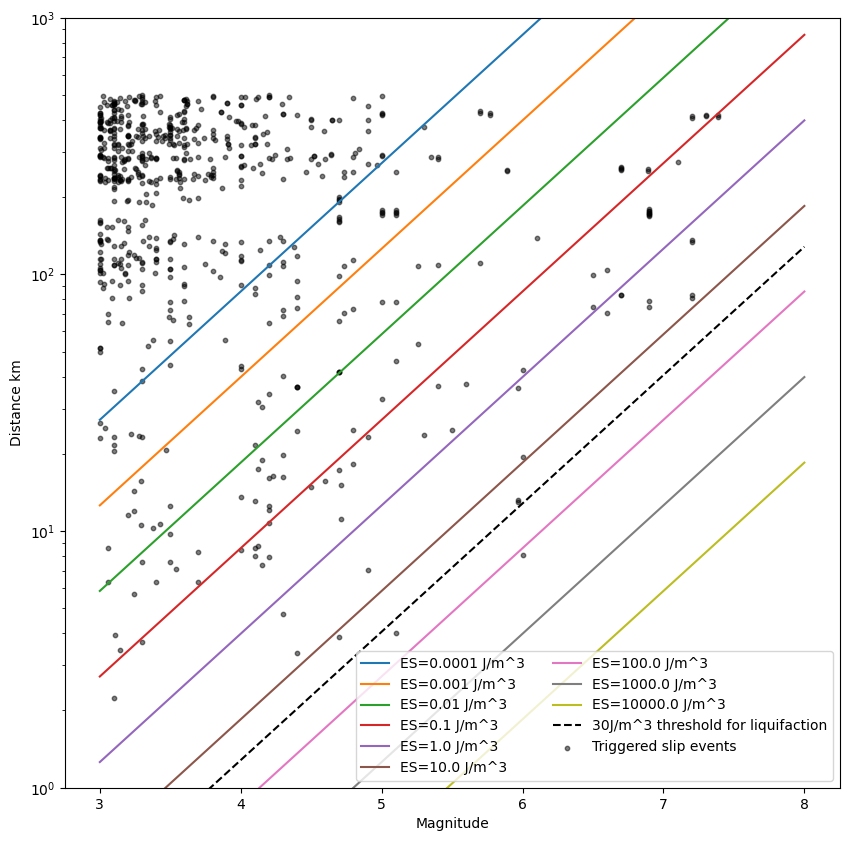

In [30]:
plt.figure(figsize=(10,10))
ES = np.logspace(-4,4,9)
M = np.linspace(3,8,100)
for i in range(len(ES)):
    plt.plot(M,10 ** ((1.5 * M - 4.2 - np.log10(ES[i])) / 3),label=f'ES={ES[i]} J/m^3')
plt.plot(M,10 ** ((1.5 * M - 4.2 - np.log10(30)) / 3),color='k',linestyle='--',label='30J/m^3 threshold for liquifaction')
plt.scatter(df_triggered['magnitude'],df_triggered['diastance km'],color='k',s=10,label='Triggered slip events',alpha=0.5)
plt.xlabel('Magnitude')
plt.ylabel('Distance km')
plt.yscale('log')
plt.ylim(1,1000)
plt.legend(ncol=2)
#plt.savefig('../../../Creep_catalog_stats_figures/New Plots/Magnitude_distance_triggered_slip_events.png',dpi=300)
plt.show()

In [31]:
df_triggered['diastance km']

0       81.715741
1       84.118813
2      236.100933
3      239.362229
4      492.724985
          ...    
704     15.723902
705     12.512886
706     24.754953
707      0.379019
708      3.359202
Name: diastance km, Length: 709, dtype: float64

In [34]:
df_triggered['M_line'] = (3.52 + 0.00072 * df_triggered['diastance km'] + 1.45 * np.log10(df_triggered['diastance km'])) / 1.08
df_triggered

,event_ID,cm latitude,cm longitude,creepmeter,creepmeter network,cm slip start time,cm next sample time,"sampling rate, s",earthquake origin time,closest_eq phase arrival time,closest_eq phase,"time difference, s",magnitude,eq latitude,eq longitude,depth km,dynamic stress kpa,step size um,diastance km,M_line
0,0007_XMR1,36.5950,-121.1870,XMR1,HOL,1981-04-25 19:30:00,1981-04-25 19:40:00,600,1981-04-25 19:41:36.880,1981-04-25 19:41:49.880,p,709.880,4.40,37.065400,-121.892400,13.200,1.518826e-02,17.111111111109523,81.715741,5.881184
1,0007_XMR1,36.5950,-121.1870,XMR1,HOL,1981-04-25 19:30:00,1981-04-25 19:40:00,600,1981-04-25 19:41:37.100,1981-04-25 19:41:51.100,p,711.100,4.10,37.112167,-121.877000,13.222,6.883756e-03,17.111111111109523,84.118813,5.899686
2,0014_XHR1,36.7720,-121.4220,XHR1,HOL,1982-06-22 00:49:59,1982-06-22 00:59:59,600,1982-06-22 01:05:28.000,1982-06-22 01:06:07.000,p,968.000,3.50,37.588900,-118.962000,2.000,4.645011e-05,10.952499999999254,236.100933,6.602763
3,0014_XHR1,36.7720,-121.4220,XHR1,HOL,1982-06-22 00:49:59,1982-06-22 00:59:59,600,1982-06-22 01:05:26.640,1982-06-22 01:06:05.640,p,966.640,3.50,37.545000,-118.901000,2.115,4.426017e-05,10.952499999999254,239.362229,6.612937
4,0014_XHR1,36.7720,-121.4220,XHR1,HOL,1982-06-22 00:49:59,1982-06-22 00:59:59,600,1982-06-22 00:26:07.880,1982-06-22 00:27:28.880,p,-1350.120,3.21,41.186167,-121.921333,9.765,1.835393e-06,5.055000000000476,492.724985,7.202814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,5600_KIR1,36.4791,36.3339,KIR1,EAF,2023-05-07 08:36:00,2023-05-07 08:37:00,60,2023-05-07 08:36:08.947,2023-05-07 08:36:10.947,p,10.947,4.60,36.360500,36.238200,10.000,7.737940e+00,187.67061728395083,15.723902,4.876235
705,5670_SIV1,38.3880,39.1873,SIV1,EAF,2023-06-27 12:39:00,2023-06-27 12:40:00,60,2023-06-27 12:40:08.287,2023-06-27 12:40:10.287,p,70.287,4.20,38.500300,39.196500,9.959,6.874748e+00,14.004938271604315,12.512886,4.740905
706,5748_BAL1,37.9903,38.1990,BAL1,EAF,2023-08-24 05:33:16,2023-08-24 05:34:16,60,2023-08-24 05:35:24.510,2023-08-24 05:35:28.510,p,132.510,4.80,38.212500,38.181500,10.000,2.513513e+00,104.36524691357984,24.754953,5.146883
707,5848_YZE1,38.1791,38.7526,YZE1,EAF,2023-11-20 07:33:21,2023-11-20 07:34:21,60,2023-11-20 07:36:05.347,2023-11-20 07:36:05.347,p,164.347,4.50,38.177200,38.749000,10.000,2.808208e+06,184.70740853658629,0.379019,2.693825


In [35]:
# Compute the model-predicted distance for the strain line
df_triggered['D_line'] = 10 ** ((df_triggered['magnitude'] - 1.1) / 1.7)

# Select data below the line (events closer than predicted for given M)
below_df = df_triggered[df_triggered['diastance km'] < df_triggered['D_line']]

below_df_Bilham_Hough = df_triggered[df_triggered['magnitude'] > df_triggered['M_line']]

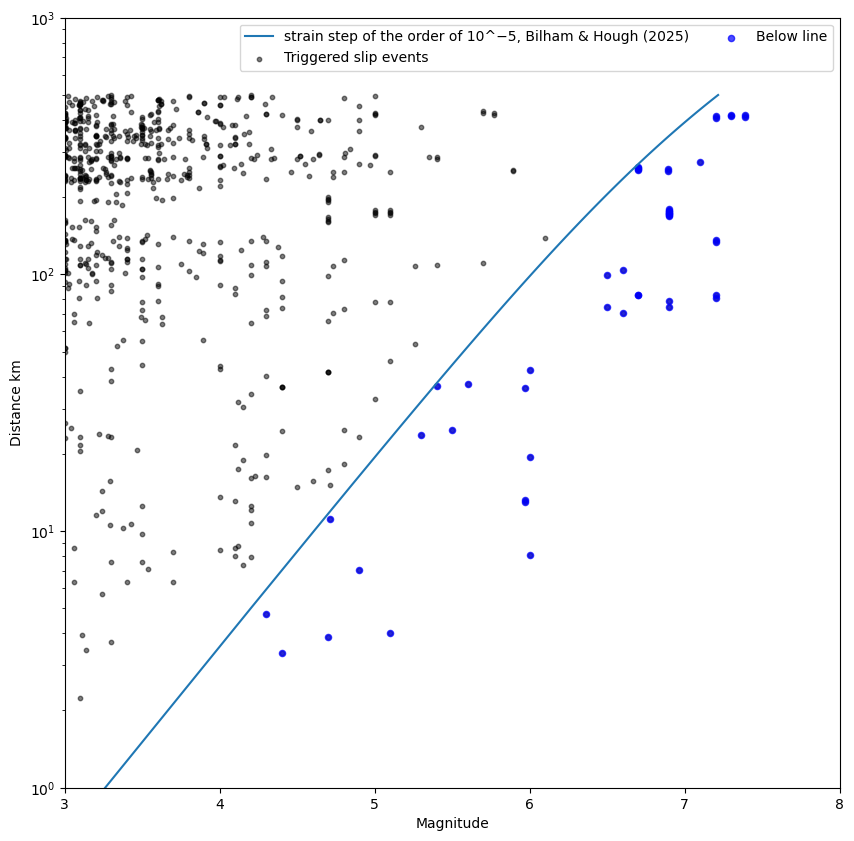

In [38]:
plt.figure(figsize=(10,10))
ES = 10E-5
D = np.linspace(0.01,500,100)
M = M_series = (3.52 + 0.00072 * D + 1.45 * np.log10(D)) / 1.08

plt.plot(M,D,label=f'strain step of the order of 10^−5, Bilham & Hough (2025)')
plt.scatter(df_triggered['magnitude'],df_triggered['diastance km'],color='k',s=10,label='Triggered slip events',alpha=0.5)
plt.scatter(below_df_Bilham_Hough['magnitude'], below_df_Bilham_Hough['diastance km'],color='blue', s=20, label='Below line', alpha=0.7)
plt.xlabel('Magnitude')
plt.ylabel('Distance km')
plt.yscale('log')
plt.ylim(1,1000)
plt.xlim(3,8)
plt.legend(ncol=2)
#plt.savefig('../../../Creep_catalog_stats_figures/New Plots/Magnitude_distance_triggered_slip_events_strain.png',dpi=300)
plt.show()

In [39]:
below_df_Bilham_Hough.to_csv('../../Data/DATA_tidied/Final_Catalogue/Creepmeter_slip_events_potentially_triggered_by_earthquakes_below_strain_line_v2.csv')

In [41]:
chosen_eqs = pd.read_csv('../../Data/DATA_tidied/Final_Catalogue/Creepmeter_slip_events_potentially_triggered_by_earthquakes_below_strain_line_v2.csv')

In [42]:
chosen_eqs['earthquake origin time']=pd.to_datetime(chosen_eqs['earthquake origin time'])
chosen_eqs

,Unnamed: 0,event_ID,cm latitude,cm longitude,creepmeter,creepmeter network,cm slip start time,cm next sample time,"sampling rate, s",earthquake origin time,...,"time difference, s",magnitude,eq latitude,eq longitude,depth km,dynamic stress kpa,step size um,diastance km,M_line,D_line
0,29,0060_XMM1,35.9580,-120.5020,XMM1,PARK,1985-08-04 12:20:00,1985-08-04 12:30:00,600,1985-08-04 12:01:55.870,...,-1072.130,5.60,36.143000,-120.156333,15.890,3.752654e+00,320.000000,37.267576,5.393762,443.668733
1,30,0060_XMM1,35.9580,-120.5020,XMM1,PARK,1985-08-04 12:20:00,1985-08-04 12:30:00,600,1985-08-04 12:01:56.350,...,-1071.650,5.40,36.131300,-120.152700,12.000,2.462879e+00,320.000000,36.845543,5.386840,338.385515
2,38,0085_XMR1,36.5950,-121.1870,XMR1,HOL,1986-01-26 19:30:00,1986-01-26 19:39:59,599,1986-01-26 19:20:50.950,...,-541.050,5.50,36.804333,-121.285000,8.153,1.239534e+01,288.666667,24.862569,5.149484,387.467512
3,39,0085_XMR1,36.5950,-121.1870,XMR1,HOL,1986-01-26 19:30:00,1986-01-26 19:39:59,599,1986-01-26 19:20:51.180,...,-541.820,5.30,36.779500,-121.320800,7.000,9.185957e+00,288.666667,23.732406,5.121605,295.520924
4,52,0245_XMR1,36.5950,-121.1870,XMR1,HOL,1988-07-26 03:09:59,1988-07-26 03:20:00,601,1988-07-26 03:26:55.640,...,1016.640,4.70,36.576833,-121.150167,3.182,1.320834e+03,681.496250,3.859539,4.049310,131.113394
5,54,0245_XMR1,36.5950,-121.1870,XMR1,HOL,1988-07-26 03:09:59,1988-07-26 03:20:00,601,1988-07-26 03:26:54.980,...,1016.980,4.90,36.535000,-121.162400,0.300,2.598931e+02,681.496250,7.024140,4.400572,171.907220
6,60,0315_XMR1,36.5950,-121.1870,XMR1,HOL,1989-10-17 23:39:59,1989-10-17 23:49:59,600,1989-10-18 00:04:14.750,...,1467.750,6.90,37.060800,-121.789500,7.600,6.628321e+00,1596.002500,74.554192,5.822929,2580.861540
7,62,0315_XMR1,36.5950,-121.1870,XMR1,HOL,1989-10-17 23:39:59,1989-10-17 23:49:59,600,1989-10-18 00:04:15.190,...,1469.190,6.90,37.036167,-121.879833,17.214,5.451222e+00,1596.002500,78.805144,5.858096,2580.861540
8,66,0316_XVA1,35.9220,-120.4620,XVA1,PARK,1989-10-18 00:00:00,1989-10-18 00:10:00,600,1989-10-18 00:04:14.750,...,282.750,6.90,37.060800,-121.789500,7.600,3.447747e-01,2083.750000,173.540804,6.381557,2580.861540
9,67,0316_XVA1,35.9220,-120.4620,XVA1,PARK,1989-10-18 00:00:00,1989-10-18 00:10:00,600,1989-10-18 00:04:15.190,...,284.190,6.90,37.036167,-121.879833,17.214,3.199745e-01,2083.750000,177.248359,6.396355,2580.861540


In [43]:
triggered_for_df = []
for i in range(len(slip_events)):
    if slip_events['Event_id'].iloc[i] in chosen_eqs['event_ID'].values:
        triggered_for_df.append('Yes')
    else:
        triggered_for_df.append('No')

In [44]:
Potential_earthquake_tigger=[]
for i in range(len(slip_events)):
    if slip_events['Event_id'].iloc[i] in chosen_eqs['event_ID'].values:
        index = np.where(chosen_eqs['event_ID'].values==slip_events['Event_id'].iloc[i])
        df_event = chosen_eqs.iloc[index]
        if len(df_event)==1:
            Potential_earthquake_tigger.append(f'Origin time(UTC): {df_event["earthquake origin time"].values[0]}, Magnitude: {df_event["magnitude"].values[0]}, Latitude: {df_event["eq latitude"].values[0]:.4f}, Longitude: {df_event["eq longitude"].values[0]:.4f}, Depth km: {df_event["depth km"].values[0]}, Epicentral distance, km: {df_event["diastance km"].values[0]:.2f}')
        if len(df_event)>1:
            event_info = []
            for j in range(len(df_event)):
                event_info.append(f'Origin time (UTC): {df_event["earthquake origin time"].values[j]}, Magnitude: {df_event["magnitude"].values[j]}, Latitude: {df_event["eq latitude"].values[j]:.4f}, Longitude: {df_event["eq longitude"].values[j]:.4f}, Depth km: {df_event["depth km"].values[j]}, Epicentral distance, km: {df_event["diastance km"].values[j]:.2f}')
            Potential_earthquake_tigger.append(" | ".join(event_info))
    else:
        Potential_earthquake_tigger.append(' ')

In [45]:
slip_events['Potentially triggered by earthquake'] = triggered_for_df
slip_events['Details of potential earthquake trigger'] = Potential_earthquake_tigger
slip_events

,Event_id,Start Time,End Time,Network,Creepmeter full name,Creepmeter abbreviation,Latitude,Longitude,Fault,Event type,"Sampling rate, s","Displacement, mm","Duration, hrs",Potentially triggered by earthquake,Details of potential earthquake trigger
0,0000_XMR1,1980-02-19 14:30:00,1980-02-20 21:29:59,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.190000,30.999722,No,
1,0001_XMR1,1980-02-21 06:29:59,1980-02-23 08:10:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.282000,49.666944,No,
2,0002_XMR1,1980-07-22 19:59:59,1980-07-24 19:30:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.211000,47.500278,No,
3,0003_XMR1,1980-09-10 09:09:59,1980-09-12 03:29:59,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,1.063000,42.333333,No,
4,0004_XMR1,1980-12-13 12:20:00,1980-12-13 20:50:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.127000,8.500000,No,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,5860_WKR1,2023-12-18 17:50:00,2023-12-20 20:50:00,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.114000,51.000000,No,
5692,5861_WKR1,2023-12-20 20:39:59,2023-12-21 16:39:59,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.152000,20.000000,No,
5693,5862_WKR1,2023-12-21 17:19:59,2023-12-22 18:40:00,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.162000,25.333611,No,
5694,5863_DS30,2023-12-23 04:59:00,2024-01-11 06:59:00,DSF,Dead Sea,DS30,31.23655,35.36525,Dead Sea Fault,Episodic Creep Event (ECE),3600,0.565803,458.000000,No,


In [47]:
slip_events.to_csv('../../Data/DATA_tidied/Final_Catalogue/Digital_catalogue_of_5000_aseismic_slip_events_recorded_by_creepmeters_with_trigger_info_v2_0_0.csv',index=False)

In [46]:
slip_events.sort_values(by='Start Time',inplace=True)
slip_events.reset_index(inplace=True,drop=True)
slip_events

,Event_id,Start Time,End Time,Network,Creepmeter full name,Creepmeter abbreviation,Latitude,Longitude,Fault,Event type,"Sampling rate, s","Displacement, mm","Duration, hrs",Potentially triggered by earthquake,Details of potential earthquake trigger
0,0000_XMR1,1980-02-19 14:30:00,1980-02-20 21:29:59,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.190000,30.999722,No,
1,0001_XMR1,1980-02-21 06:29:59,1980-02-23 08:10:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.282000,49.666944,No,
2,0002_XMR1,1980-07-22 19:59:59,1980-07-24 19:30:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.211000,47.500278,No,
3,0003_XMR1,1980-09-10 09:09:59,1980-09-12 03:29:59,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,1.063000,42.333333,No,
4,0004_XMR1,1980-12-13 12:20:00,1980-12-13 20:50:00,HOL,Melendy Ranch,XMR1,36.59500,-121.18700,San Andreas Fault - Hollister,Episodic Creep Event (ECE),600,0.127000,8.500000,No,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,5859_KIR1,2023-12-09 12:14:45,2023-12-10 05:49:45,EAF,Kirikhan,KIR1,36.47910,36.33390,East Anatolian Fault,Creeplet (CLTS),60,0.052654,17.583333,No,
5692,5860_WKR1,2023-12-18 17:50:00,2023-12-20 20:50:00,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.114000,51.000000,No,
5693,5861_WKR1,2023-12-20 20:39:59,2023-12-21 16:39:59,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.152000,20.000000,No,
5694,5862_WKR1,2023-12-21 17:19:59,2023-12-22 18:40:00,PARK,Work Ranch,WKR1,35.85800,-120.39200,San Andraes Fault - Parkfield,Episodic Creep Event (ECE),600,0.162000,25.333611,No,


In [47]:
slip_events.to_csv('../../../Data/DATA_tidied/Final_Catalogue/Digital_catalogue_of_5000_aseismic_slip_events_recorded_by_creepmeters_with_trigger_info_v2_0_0.csv',index=False)

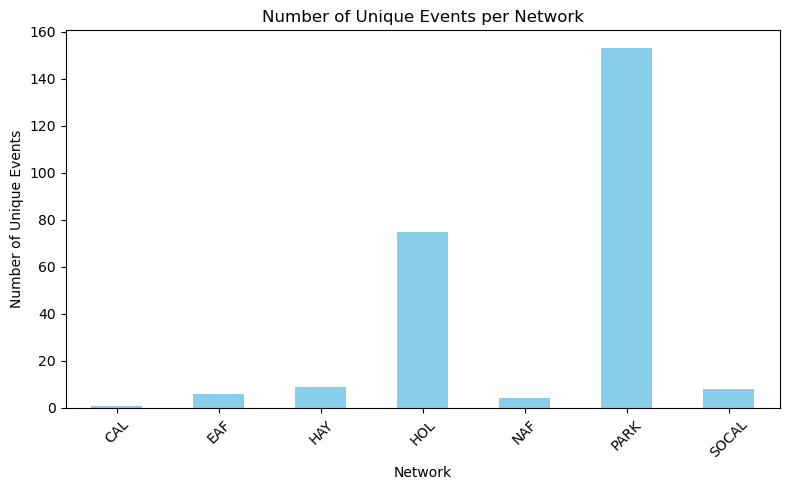

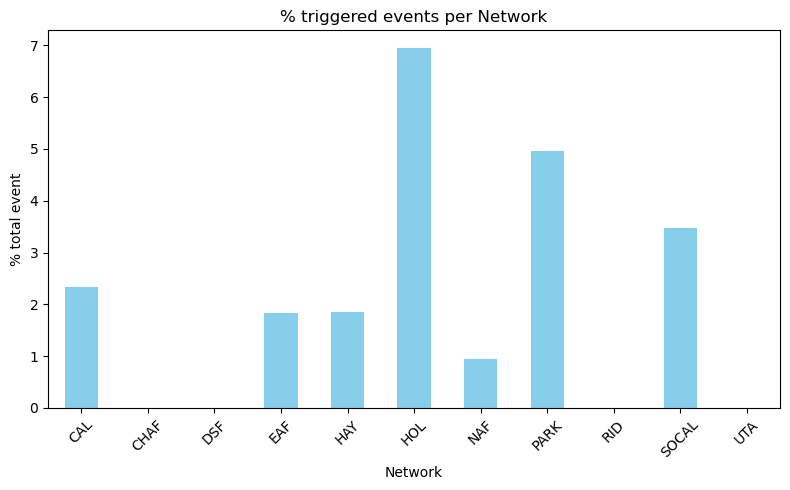

In [ ]:

import matplotlib.pyplot as plt

network_counts = df_no_dupe.groupby('creepmeter network')['event_ID'].count()
event_region = slip_events.groupby('Network')['Event_id'].count()
trigger_per = (network_counts/event_region)*100

network_counts.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.xlabel('Network')
plt.ylabel('Number of Unique Events')
plt.title('Number of Unique Events per Network')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

trigger_per.plot(kind='bar', figsize=(8,5), color='skyblue')
plt.xlabel('Network')
plt.ylabel('% total event')
plt.title('% triggered events per Network')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_triggered[df_triggered['event_ID']=='3228_SU30'].sort_values(by='earthquake origin time')

,event_ID,cm latitude,cm longitude,creepmeter,creepmeter network,cm slip start time,cm next sample time,"sampling rate, s",earthquake origin time,closest_eq phase arrival time,closest_eq phase,"time difference, s",magnitude,eq latitude,eq longitude,depth km,dynamic stress kpa,step size um,diastance km
601,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:34:50.620,2010-04-04 22:35:16.620,surface,-583.38,3.60,32.323100,-115.260600,24.500,0.002714,22842.603333333333,79.112556
602,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:40:42.360,2010-04-04 22:41:08.360,surface,-231.64,7.20,32.286167,-115.295333,9.987,9.926634,19036.571666666667,81.075031
603,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:40:43.650,2010-04-04 22:41:10.650,surface,-229.35,7.20,32.276400,-115.263300,5.200,8.962192,19036.571666666667,83.468902
604,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:43:00.430,2010-04-04 22:43:17.430,surface,-102.57,5.26,32.453333,-115.632000,9.981,0.492290,19036.571666666667,53.426835
605,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:43:30.550,2010-04-04 22:43:44.550,surface,-75.45,3.50,32.534000,-115.742500,-0.060,0.016563,19036.571666666667,44.238076
606,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:44:36.140,2010-04-04 22:44:52.140,surface,-7.86,3.00,32.483000,-115.678500,6.993,0.003465,19036.571666666667,49.781697
608,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:45:20.320,2010-04-04 22:45:37.320,surface,37.32,3.00,32.469667,-115.621333,6.122,0.003023,19036.571666666667,51.758428
600,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:46:09.740,2010-04-04 22:46:27.740,surface,87.74,3.50,32.441000,-115.611167,10.038,0.007702,19036.571666666667,55.052036
607,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:47:57.980,2010-04-04 22:48:14.980,surface,194.98,3.34,32.898500,-116.265167,13.514,0.006072,19036.571666666667,52.790766
599,3228_SU30,32.9303,-115.7009,SU30,SOCAL,2010-04-04 22:45:00,2010-04-04 23:00:00,900.0,2010-04-04 22:50:17.120,2010-04-04 22:50:53.120,surface,353.12,5.70,32.098667,-115.048167,10.011,0.104749,19036.571666666667,110.892467


Network
CAL        43
CHAF        4
DSF        16
EAF       328
HAY       486
HOL      1080
NAF       422
PARK     3079
RID         1
SOCAL     230
UTA         6
Name: Event_id, dtype: int64

CAL      2.325581
CHAF          NaN
DSF           NaN
EAF      1.829268
HAY      1.851852
HOL      6.944444
NAF      0.947867
PARK     4.969146
RID           NaN
SOCAL    3.478261
UTA           NaN
dtype: float64